<a href="https://colab.research.google.com/github/LotanLevy/DOC/blob/master/pinto_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu==2.3.0

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:

import cv2
from PIL import Image
from tensorflow.keras.applications import mobilenet_v2, vgg16


def resize(x, size=96):
    x_out = []
    for i in range(len(x)):
      img = x[i]
      if img.shape[-1] == 1:
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
      img = cv2.resize(img,dsize=(size,size))
      x_out.append(img)

    return np.array(x_out)

def mobilenet_v2_preprocessing(input_data):
  return resize(input_data.astype('float32')/ 255, size=size)


def vgg_preprocessing(input_data):
  # return vgg16.preprocess_input(resize(np.copy(input_data).astype('float32'), size=size))
    return vgg16.preprocess_input(np.copy(input_data))

In [55]:
import os
import numpy as np 
from PIL import Image
from sklearn.model_selection import train_test_split


class DataIter:
  def __init__(self, data, labels, batch_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
    if labels is not None:
        assert(len(data) == len(labels))
        self.labels = np.array(labels)
    else:
      self.labels = None

    self.preprocess_func = preprocess_func

    self.data = data
    self.classes_num = classes_num
    self.batch_size = batch_size
    self.indices = np.arange(len(self.data)).astype(np.int)
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indices)
    self.cur_idx = 0

  def next(self):
    relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
    self.cur_idx += self.batch_size
    images = self.data[relevant_indices]
    if self.labels is not None:
      labels = self.labels[relevant_indices]
      labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
    else:
      labels = None
    return self.preprocess_func(images), labels

  def get_all_data(self, size=None):
    if size is None:
      size = len(self.data)
    return self.preprocess_func(self.data[:size])

  def __len__(self):
    return len(self.data)



class DirIter:
    def __init__(self, paths, labels, batch_size, input_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
      if labels is not None:
        assert(len(paths) == len(labels))
        self.labels = np.array(labels)
      else:
        self.labels = None
      self.preprocess_func = preprocess_func

      self.paths = paths
      self.classes_num = classes_num
      self.batch_size = batch_size
      self.indices = np.arange(len(self.paths)).astype(np.int)
      self.input_size = input_size
      self.shuffle = shuffle
      self.on_epoch_end()

    def __len__(self):
      return len(self.paths)

    def on_epoch_end(self):
      if self.shuffle and len(self.indices) > 0:
        np.random.shuffle(self.indices)
      self.cur_idx = 0

    def load_img(self, image_path):
        image = Image.open(image_path, 'r')
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = image.resize(self.input_size, Image.NEAREST)
        image = np.array(image).astype(np.float32)
        return np.expand_dims(image, axis=0)

    def next(self):
        relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
        self.cur_idx += self.batch_size
        images = np.concatenate([self.load_img(self.paths[i]) for i in relevant_indices])
        if self.labels is not None:
          labels = self.labels[relevant_indices]
          labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
        else:
          labels = None
        return self.preprocess_func(images), labels

    def get_all_data(self, size=None):
      if size is None:
        size = len(self.paths)
      images = np.concatenate([self.load_img(path) for i in self.paths[:size]])
      return self.preprocess_func(images)

    def set_cls2label_map(self, map):
        self.cls2label = map


def get_iterators_by_root_dir(root_dir, batch_size, input_size, split_val, classes_num, shuffle=False):
    dirs = os.listdir(root_dir)
    length = len(max(dirs, key=len))

    for dir in dirs: # Handle the sort problem pads the clas num with '0'
        if len(dir) < length:
          zeros = "0" * (length - len(dir))
          new_name = zeros + dir

          os.rename(os.path.join(root_dir, dir), os.path.join(root_dir, new_name))
          print("old {}, new {}".format(dir, new_name))

    paths = []
    labels = []
    cls2label = dict()
    label_idx = 0
    for sub_dir in sorted(os.listdir(root_dir)):

        full_path = os.path.join(root_dir, sub_dir)
        if not os.path.isdir(full_path):
            continue
        cls2label[sub_dir] = label_idx
        for file in os.listdir(full_path):
            paths.append(os.path.join(full_path, file))
            labels.append(label_idx)
        label_idx += 1

    print(cls2label)


    assert len(paths) == len(labels)
    if len(cls2label) != classes_num:
        print("classes in directory doesn't match classes_num")

    if split_val > 0:
      X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=split_val, shuffle=shuffle)
    else:
      X_train, X_test, y_train, y_test = paths, [], labels, []

    print(list(zip(X_train, y_train)))

    train_iter = DirIter(X_train, y_train, batch_size, input_size, classes_num, shuffle=True)
    val_iter = DirIter(X_test, y_test, batch_size, input_size, classes_num, shuffle=(True))

    train_iter.set_cls2label_map(cls2label)
    val_iter.set_cls2label_map(cls2label)
    return train_iter, val_iter



In [56]:
from keras.datasets import fashion_mnist
import numpy as np

def get_fmnist_data_loaders():
  # dataset
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

  #Splitting the into subsets data
  x_train_s, x_test_s, x_test_b = [], [], []
  x_ref, y_ref = [], []

  x_train_shape = x_train.shape
  #train data
  for i in range(len(x_train)):
      if y_train[i] == 7: #Sneakers is 7
          temp = x_train[i]
          x_train_s.append(temp.reshape((x_train_shape[1:])))
      else:
          temp = x_train[i]
          x_ref.append(temp.reshape((x_train_shape[1:])))
          y_ref.append(y_train[i])

  x_ref, y_ref = np.array(x_ref), np.array(y_ref)

  #test data
  for i in range(len(x_test)):
      if y_test[i] == 7: #Sneakers is 7
          temp = x_test[i,:,:,:]
          x_test_s.append(temp.reshape((x_train_shape[1:])))

      if y_test[i] == 9: #Boots is 9
          temp = x_test[i,:,:,:]
          x_test_b.append(temp.reshape((x_train_shape[1:])))

  #tdata loaders
  train_s_loader = DataIter(np.array(x_train_s), None, batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)
  ref_loader = DataIter(np.array(x_ref), np.array(y_ref), batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)

  test_s_loader = DataIter(np.array(x_test_s), None, batchsize, classes, preprocess_func=preprocessing_func)
  test_b_loader = DataIter(np.array(x_test_b), None, batchsize, classes, preprocess_func=preprocessing_func)
  return  train_s_loader, ref_loader, test_s_loader, test_b_loader




In [57]:



def get_imagenet_clatech_loaders(ref_path, tar_path, alien_path, batchsize, input_size, split_val, cls_num, shuffle=False):
  ref_loader, i1 = get_iterators_by_root_dir(ref_path, batchsize, input_size, 0, cls_num, shuffle=shuffle)
  train_s_loader, test_s_loader = get_iterators_by_root_dir(ref_path, batchsize, input_size, split_val, cls_num, shuffle=shuffle)
  test_alien_loader, i2 = get_iterators_by_root_dir(ref_path, batchsize, input_size, 0, cls_num, shuffle=shuffle)
  print(len(ref_loader), len(i1))
  print(len(train_s_loader), len(test_s_loader))
  print(len(test_alien_loader), len(i2))

  return  train_s_loader, ref_loader, test_s_loader, test_alien_loader



In [58]:
import tensorflow as tf





# MobileNetV2
size = 96
preprocessing_func = mobilenet_v2_preprocessing
first_trained_layer_name = "block_13_expand"
alpha = 0.5 #for MobileNetV2
network_constractor = lambda : tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')


# VGG16
# size = 224
# preprocessing_func = vgg_preprocessing
# first_trained_layer_name =  "block5_conv1"
# network_constractor = lambda : tf.keras.applications.VGG16(include_top=True, input_shape=(size, size, 3), weights='imagenet')
# test_size = 200



lambda_ = 0.1 #for compact loss

# fmnist data
classes = 10
batchsize = 2
train_s_loader, ref_loader, test_s_loader, test_b_loader = get_fmnist_data_loaders()

# # imagenet clatech data
REFERENCE_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/imagenet_val_splitted"
TARGET_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/flags"
ALIEN_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/alien"
classes = 1000
batchsize = 2
split_val = 0.2

train_s_loader, ref_loader, test_s_loader, test_b_loader = get_imagenet_clatech_loaders(REFERENCE_PATH, TARGET_PATH, ALIEN_PATH, batchsize, (size,size,3), split_val, classes, shuffle=True)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model build...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56,

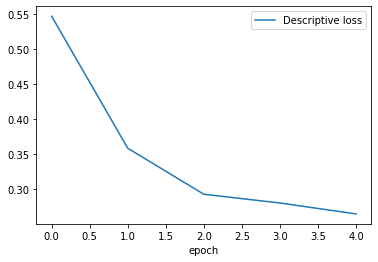

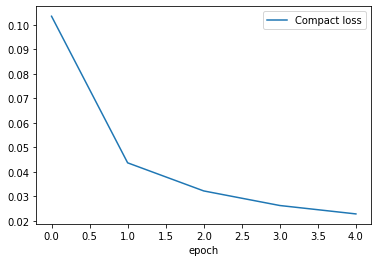

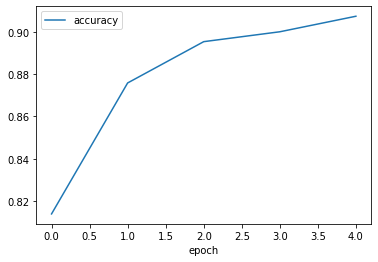

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt





#Loss function
def original_loss(y_true, y_pred):
    n_dim = np.shape(y_pred)[0]  # number of features vecs
    k_dim = np.shape(y_pred)[1]  # feature vec dim
    print(n_dim,k_dim, classes*batchsize)

    lc = 1/(k_dim*n_dim)* n_dim**2 * K.sum((y_pred - K.mean(y_pred,axis=0))**2,axis=[1]) / ((n_dim-1)**2)
    return lc

#Learning
def train(target_dataloader, reference_dataloader, epoch_num):

    print("Model build...")

    network = network_constractor()


    #Fixed weight
    for layer in network.layers:
        if layer.name == first_trained_layer_name:
            break
        else:
            layer.trainable = False

    model_t = Model(inputs=network.input,outputs=network.layers[-2].output)

    #Apply a Fully Connected Layer to R
    prediction = Dense(classes, activation='softmax')(model_t.output)
    model_r = Model(inputs=model_t.input,outputs=prediction)

    
    #Compile
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    optimizer = SGD(lr=5e-5, decay=0.00005)
    model_r.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[train_accuracy])
    model_t.compile(optimizer=optimizer, loss=original_loss)


    model_t.summary()
    model_r.summary()

    print("x_target is", len(target_dataloader),'samples')
    print("x_ref is",len(reference_dataloader),'samples')

    loss, loss_c, epoch_accuracy = [], [], []

    print("training...")

    #Learning
    for epochnumber in range(epoch_num):
        lc, ld, accuracy = [], [], []
        for i in range(int(len(target_dataloader) / batchsize)):
            #Load data for batch size
            batch_target, _ = target_dataloader.next()
            batch_ref, batch_y = reference_dataloader.next()


            #target data
            #Get loss while learning
            lc.append(model_t.train_on_batch(batch_target, np.zeros((batchsize, 4096))))

            #reference data
            #Get loss while learning
            ref_output = model_r.train_on_batch(batch_ref, batch_y)
            ld.append(ref_output[0])
            accuracy.append(ref_output[1])

        train_s_loader.on_epoch_end()
        ref_loader.on_epoch_end()

        loss.append(np.mean(ld))
        loss_c.append(np.mean(lc))
        epoch_accuracy.append(np.mean(accuracy))
        print("epoch: {}, Descriptive loss: {}, Compact loss: {}, accuracy: {}".format(epochnumber+1, loss[-1], loss_c[-1], epoch_accuracy[-1]))



    #Result graph
    plt.plot(loss,label="Descriptive loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(loss_c,label="Compact loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show() 

    plt.plot(epoch_accuracy,label="accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()   

    return model_t



model = train(train_s_loader, ref_loader, 5)

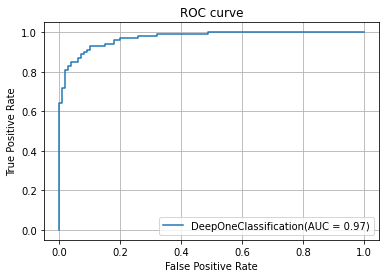

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


X_test_s = test_s_loader.get_all_data(size=40)
X_test_b = test_b_loader.get_all_data(size=100)
X_train_s = train_s_loader.get_all_data(size=100)


train = model.predict(X_train_s)
test_s = model.predict(X_test_s)
test_b = model.predict(X_test_b)

train = train.reshape((len(X_train_s),-1))
test_s = test_s.reshape((len(X_test_s),-1))
test_b = test_b.reshape((len(X_test_b),-1))

#Convert to 0-1
ms = MinMaxScaler()
train = ms.fit_transform(train)
test_s = ms.transform(test_s)
test_b = ms.transform(test_b)

# fit the model
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit(train)

#Abnormal score
Z1 = -clf._decision_function(test_s)
Z2 = -clf._decision_function(test_b)

#Drawing of ROC curve
y_true = np.zeros(len(test_s)+len(test_b))
y_true[len(test_s):] = 1 #0:Normal, 1：Abnormal

#Calculate FPR, TPR(, Threshould)
fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

#AUC
auc = metrics.auc(fpr, tpr)

#Plot the ROC curve
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

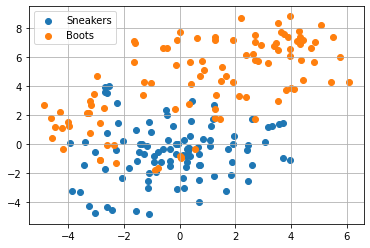

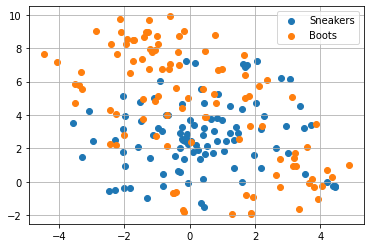

In [17]:
from sklearn.manifold import TSNE


new_network = network_constractor()




# new_mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')

untrained_test_s = new_network.predict(X_test_s)
untrained_test_b = new_network.predict(X_test_b)

untrained_test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
untrained_test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(untrained_test_s_embedded[:, 0],untrained_test_s_embedded[:,1], label="Sneakers")
plt.scatter(untrained_test_b_embedded[:, 0],untrained_test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()


test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(test_s_embedded[:, 0],test_s_embedded[:,1], label="Sneakers")
plt.scatter(test_b_embedded[:, 0],test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()
